In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import os

In [ ]:
base_dir ='/content/drive/MyDrive/Colab Notebooks/Data Analytics codes/Analyzing fire images DA project Fall 20 /Dataset/Training/'
validation_dir ='/content/drive/MyDrive/Colab Notebooks/Data Analytics codes/Analyzing fire images DA project Fall 20 /Dataset/Validation/'
fire_dir =base_dir +'Fire/'
non_fire_dir =base_dir +'Non Fire/'
fire_v_dir =validation_dir +'Fire/'
non_fire_v_dir =validation_dir +'Non Fire/'

In [ ]:
CLASSES = ["Non Fire", "Fire"]

In [ ]:
# define the size of the training and testing split
TRAIN_SPLIT = 0.75
TEST_SPLIT = 0.25
# define the initial learning rate, batch size, and number of epochs
INIT_LR = 0.1 #1e-2
BATCH_SIZE = 64
NUM_EPOCHS = 100

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
class FireDetectionNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# CONV => RELU => POOL
		model.add(SeparableConv2D(16, (7, 7), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		# CONV => RELU => POOL
		model.add(SeparableConv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
  
		# (CONV => RELU) * 2 => POOL
		model.add(SeparableConv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(SeparableConv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
  
		model.add(Flatten())
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))
  
		# second set of FC => RELU layers
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))
    
		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))
  
		# return the constructed network architecture
		return model

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import sys
from tqdm import tqdm

In [ ]:
def load_dataset(datasetPath):
	# grab the paths to all images in our dataset directory, then
	# initialize our lists of images
	imagePaths = list(paths.list_images(datasetPath))
	data = []
	# loop over the image paths
	for imagePath in tqdm(imagePaths):
		# load the image and resize it to be a fixed 128x128 pixels,
		# ignoring aspect ratio
		image = cv2.imread(imagePath)
		image = cv2.resize(image, (128, 128))
		# add the image to the data lists
		data.append(image)
	# return the data list as a NumPy array
	return np.array(data, dtype="float32")

In [ ]:
# load the fire and non-fire images
print("loading data...")
fireData = load_dataset(fire_dir)
nonFireData = load_dataset(non_fire_dir)
# construct the class labels for the data
fireLabels = np.ones((fireData.shape[0],))
nonFireLabels = np.zeros((nonFireData.shape[0],))
# stack the fire data with the non-fire data, then scale the data
# to the range [0, 1]
data = np.vstack([fireData, nonFireData])
labels = np.hstack([fireLabels, nonFireLabels])
data /= 255

loading data...


100%|██████████| 488/488 [06:31<00:00,  1.25it/s]


In [ ]:
# perform one-hot encoding on the labels and account for skew in the
# labeled data
labels = to_categorical(labels, num_classes=2)
classTotals = labels.sum(axis=0)
classWeight = classTotals.max() / classTotals
# construct the training and testing split
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=TEST_SPLIT, random_state=42)

In [ ]:
aug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
print("[INFO] compiling model...")
import tensorflow

lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(
    INIT_LR,
    decay_steps=10,
    decay_rate=0.9, #0.96
    staircase=True)

opt = RMSprop(learning_rate=lr_schedule)
model = FireDetectionNet.build(width=128, height=128, depth=3,
	classes=2)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d (SeparableC (None, 128, 128, 16)      211       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 64, 64, 32)        688       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        1

In [ ]:
# train the network
print("[INFO] training network...")
history = model.fit(
	aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
	epochs=NUM_EPOCHS,
	class_weight=classWeight,
	verbose=1)

[INFO] training network...
Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
20/20 [==============================] - 12s 590ms/step - loss: 3.6062 - acc: 0.6552 - val_loss: 3.9980 - val_acc: 0.7403
Epoch 2/100
20/20 [==============================] - 5s 253ms/step - loss: 1.6156 - acc: 0.7203 - val_loss: 3.9980 - val_acc: 0.7403
Epoch 3/100
20/20 [==============================] - 5s 245ms/step - loss: 0.6049 - acc: 0.7618 - val_loss: 3.9372 - val_acc: 0.7403
Epoch 4/100
20/20 [==============================] - 5s 250ms/step - loss: 0.5210 - acc: 0.7414 - val_loss: 3.1691 - val_acc: 0.7289
Epoch 5/100
20/20 [==============================] - 5s 246ms/step - loss: 0.4797 - acc: 0.7702 - val_loss: 10.6809 - val_acc: 0.2620
Epoch 6/100
20/20 [==============================] - 5s 241ms/step - loss: 0.4377 - acc: 0.7945 - val_loss: 3.0076 - val_acc: 0.7631
Epoch 7/100
20/20 [==============================] - 5s 248ms/step - loss: 0.41

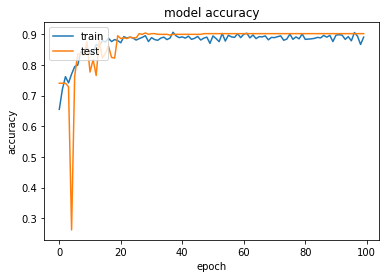

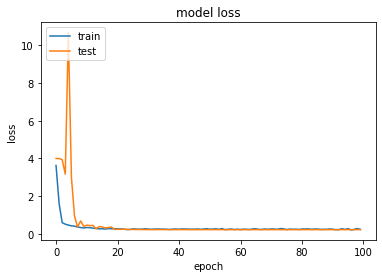

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

# Plotting history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plotting history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()